<a href="https://colab.research.google.com/github/Eugene31415/Data_science/blob/main/Simpsons_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

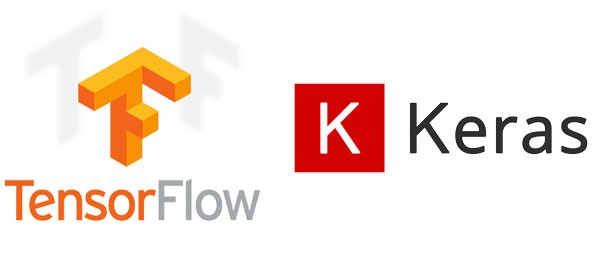

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
from pathlib import Path
import shutil
import random
from IPython.display import Audio

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D, Input
from keras import Sequential
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from skimage.io import imread, imsave

from sklearn.model_selection import train_test_split

#Загружаем на колаб train и test папки с картинками и разархивируем их и подключаем колаб к гугл диску

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

!unzip -q /content/gdrive/My\ Drive/simpsons/data/dataset.zip -d train
!unzip -q /content/gdrive/My\ Drive/simpsons/data/testset.zip -d test

Mounted at /content/gdrive/


#Первый вариант: Загружаем датасет в память

In [ ]:
# dir_train = Path('train/dataset')
# dir_test = Path('test/testset')

# train_files = sorted(list(dir_train.rglob('*.jpg')))
# test_files = sorted(list(dir_test.rglob('*.jpg')))


# train_list = []
# test_list = []

# for f in train_files:
#     train_list.append((Image.open(f),f.parent.name))

# # for f in test_files:
# #     test_list.append((Image.open(f),f.parent.name))

# train_list = np.array(train_list)
# # test_list = np.array(test_list)

ОЗУ ( оперативка/ оперативно запоминающее устройство ) переполняется и не получается сохранить все картинки в памяти... Поэтому будем использовать что-то другое...

#Создаем датасет KERAS

Работает как генератор или на языке пайторча - даталоудер. Он, я так понимаю, берет из директории опр количество картинок и передает их в модель, таким образом не загружая слишком ОЗУ

In [ ]:
train_set = image_dataset_from_directory('/content/train/dataset/simpsons_dataset',image_size=(224, 224),labels="inferred")

Found 20933 files belonging to 42 classes.


#Создаем новые картинки в классах, где их меньше Amount

In [ ]:
def expend_dataset(file_dir,amount):
    for c in os.listdir(file_dir):
        cdir = file_dir + c
        num = len(os.listdir(cdir))
        if num < amount:
            print(c)
            print('before: ', num)
            index = 0
            while num != amount:
                rand_img_file = random.choice(os.listdir(cdir))
                a = imread(cdir + '/' + rand_img_file)
                
                new_a = ImageDataGenerator().apply_transform(a,transform_parameters ={'flip_horizontal':random.choice([True,False]),
                                                                                    'theta':10,
                                                                                        'brightness':random.uniform(0.8, 1.3)} )
                imsave(cdir + '/' + Path(rand_img_file).name[:-4] + '_' + str(index) + '.jpg',new_a) # try .astype(np.uint8)
                num += 1
                index += 1
            print('After: ', len(os.listdir(cdir)))

#Создаем и разделяем массивы с названиями картинок на train и validation выборки

In [ ]:
def split_train_val(size=0.25):
    TRAIN_DIR = Path('/content/train/dataset/simpsons_dataset')

    train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
    train_val_labels = [path.parent.name for path in train_val_files]

    train_files, valid_files = train_test_split(train_val_files, test_size=size, stratify=train_val_labels)

    return train_files, valid_files

#Создаем директорию **train_files** (**valid_files**) и перекидываем туда картинки для тренировки

In [ ]:
def create_train_files(train_files):
    if Path.cwd() != '/content':
        os.chdir('/content')


    if os.path.isdir('train_files') is False:
        os.mkdir('train_files')

    os.chdir('train_files')


    for c in train_files:
        if os.path.isdir(Path(c).parent.name) is False:
            os.mkdir(Path(c).parent.name)
        shutil.copy(c,(Path(c).parent.name))

def create_valid_files(valid_files):
    if Path.cwd() != '/content':
        os.chdir('/content')

    if os.path.isdir('valid_files') is False:
        os.mkdir('valid_files')

    os.chdir('valid_files')

    for c in valid_files:
        if os.path.isdir(Path(c).parent.name) is False:
            os.mkdir(Path(c).parent.name)
        shutil.copy(c,(Path(c).parent.name))

#Проверка на размерности директорий

In [ ]:
def check_dirs():
    All = len(list(Path('/content/train').rglob('*.jpg')))
    Train = len(list(Path('/content/train_files').rglob('*.jpg')))
    Valid = len(list(Path('/content/valid_files').rglob('*.jpg')))
    print('All: ', All)
    print('Train: ', Train)
    print('Valid: ', Valid)
    print('Check that all works OK: ', '%.2f  %.2f' % (Train/All, Valid/All))
check_dirs()

All:  20933
Train:  0
Valid:  0
Check that all works OK:  0.00  0.00


#Полезные функции

In [ ]:
# По индексу получить имя персонажа
def get_name(idx):
    lst = (sorted(os.listdir('/content/train/dataset/simpsons_dataset')))
    return lst[idx]

# Отобразить картинки генератора (с аугментацией)
def disp_generator(data_gen):
    a = next(data_gen)
    fig, ax = plt.subplots(1,6,figsize=(20,20))
    ax.ravel()
    for i in range(6):
        ax[i].imshow(a[0][i])

# Отобразить картинки датасета
def disp_dataset(data_set):
    sample = next(iter(data_set))
    sample_labels = sample[1]
    fig, ax = plt.subplots(1, 6, figsize=(20,20))
    ax = ax.ravel()
    for i in range(6):
        ax[i].imshow(np.array(sample[0][i]).astype('uint8'))
        ax[i].set_title(get_name(int(sample_labels[i])))

# Отобразить историю обучени модели (loss и accuracy)
def disp_history(history):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax.ravel()
    loss = history.history['loss']
    acc = history.history['accuracy']
    ax[0].plot(loss)
    ax[0].set_title('loss')
    ax[0].grid()
    ax[1].plot(acc)
    ax[1].set_title('accuracy')
    ax[1].grid()

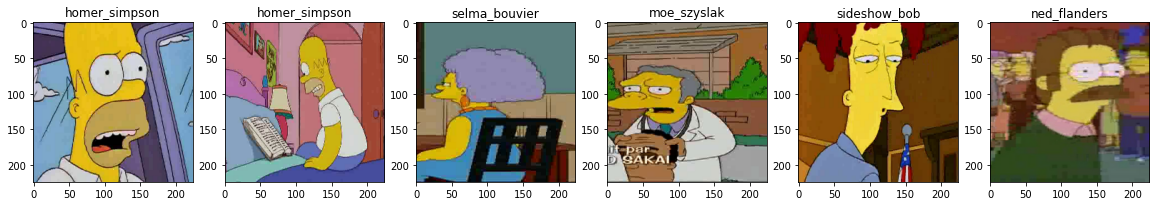

In [ ]:
disp_dataset(train_set)

#ImageDataGenerator - нужен для аугментации картинок на лету, чтобы не перегружать ОЗУ

In [ ]:
def create_generator(file_dir,mode,batch=32,img_size=(224,224)):
    if mode == 'train' or 'final':
        train_datagen = ImageDataGenerator(
            rescale=1/255.,
            shear_range=0.6,
            zoom_range=(0.8, 1.5),
            horizontal_flip=True,
            rotation_range=20,
            brightness_range=(0.8, 1.3)                     
        )
        return train_datagen.flow_from_directory(file_dir,
                                                target_size=img_size,
                                                batch_size=batch,
                                                shuffle=True)
    elif mode == 'valid' or 'test':
        valid_datagen = ImageDataGenerator(
            rescale=1/255.
        )
        return train_datagen.flow_from_directory(file_dir,
                                                target_size=img_size,
                                                batch_size=batch)

#Функция для обучения модели

In [ ]:
def train(model,
          train_set,
          val_set=None,
          epochs=1,
          lr=1e-4,
          callback=None):

    model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=lr),
                metrics=['accuracy', keras.metrics.AUC()])
                

    return model.fit(train_set,
                    epochs=epochs,
                    validation_data=val_set,
                    verbose=1,
                    callbacks=[callback])

#Проверка звука

In [ ]:
sound_file = '/content/gdrive/MyDrive/music.mp3'
Audio(str,sound_file, autoplay=True)

In [ ]:
train_files, valid_files = split_train_val(0.1)
create_train_files(train_files)
create_valid_files(valid_files)

In [ ]:
expend_dataset('/content/train/dataset/simpsons_dataset/',500)

In [ ]:
check_dirs()

All:  31210
Train:  28089
Valid:  3121
Check that all works OK:  0.90  0.10


In [ ]:
train_gen = create_generator('/content/train_files', mode='train',batch=128)
valid_gen = create_generator('/content/valid_files', mode='valid')
final_gen = create_generator('/content/train/dataset/simpsons_dataset', mode='final',batch=128)

Found 28089 images belonging to 42 classes.
Found 3121 images belonging to 42 classes.
Found 31210 images belonging to 42 classes.


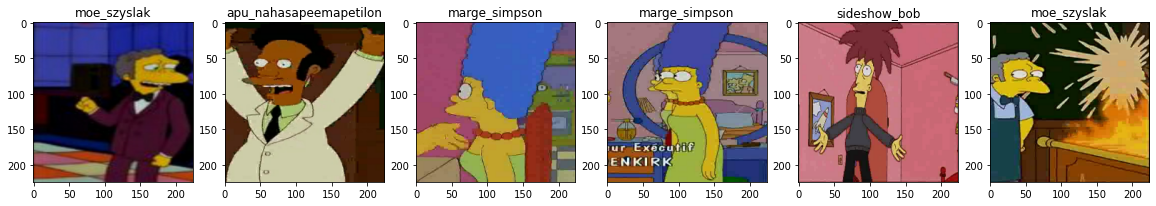

In [ ]:
disp_dataset(train_set)

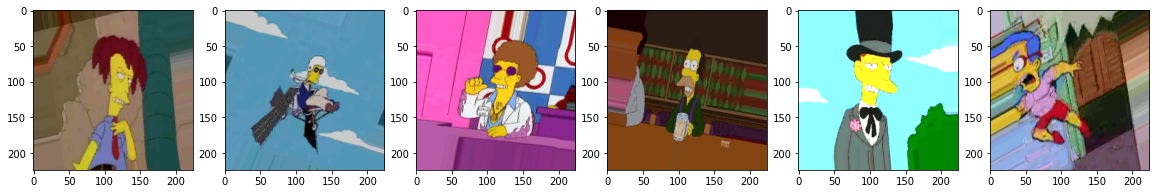

In [ ]:
disp_generator(train_gen)

#===============  Создание и обучение обычной модели  ===================

In [ ]:
model = Sequential([
    Conv2D(8,(3,3),activation='relu'),
    MaxPool2D(),
    Conv2D(16,(3,3),activation='relu'),
    MaxPool2D(),
    Conv2D(32,(3,3),activation='relu'),
    MaxPool2D(),
    Conv2D(64,(3,3),activation='relu'),
    MaxPool2D(),
    Conv2D(96,(3,3),activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(42,activation='softmax')
])

# train(model,train_gen,valid_gen,epochs=1)

#===============  Transfer learning  ===================

Скачать модель из базы данных
> https://medium.com/towards-artificial-intelligence/batchnorm-for-transfer-learning-df17d2897db6



In [ ]:
VGG16 = keras.applications.VGG16(include_top=False,
                                     weights='imagenet',
                                     input_tensor=keras.Input(shape=(224,224,3)))

Создать модель, для симпсонов на основе скачанной из базы данных

In [ ]:
model = Sequential()
model.add(VGG16)
model.add(Flatten())
model.add(Dense(42,activation='softmax'))

заморозить / разморозить определенные слои

In [ ]:
for layer in model.layers[0].layers[:]:
    layer.trainable = True

Проверить заморозку / разморозку слоев

In [ ]:
for i, layer in enumerate(model.layers[0].layers):
    print(i, layer.name,'-',layer.trainable)
for i, layer in enumerate(model.layers[1:]):
    print(i, layer.name,'-',layer.trainable)

имя для сохранения и загрузки модели


In [ ]:
name = '/content/gdrive/MyDrive/keras_simpsons/model_VGG16_(Full)'

Загрузить модель

In [ ]:
model = keras.models.load_model(name)

функция для SCHEDULER and CALLBACK

In [ ]:
def scheduler(epoch, lr):
    if epoch < 5:
      return lr
    else:
      return lr * tf.math.exp(-0.1)

callback = keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
model.save(name)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/keras_simpsons/model_VGG16_(15)/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/keras_simpsons/model_VGG16_(15)/assets


Обучить и сохранить модель

In [ ]:
history = train(model,final_gen,valid_gen,epochs=20,lr=1e-6,callback=callback)

sound_file = '/content/gdrive/MyDrive/music.mp3'
Audio(str,sound_file, autoplay=True)

model.save(name)


Составить предсказания и датафрейм 

In [ ]:
TEST_DIR = '/content/test/testset/testset/'
test_filenames = sorted([pic for pic in os.listdir(TEST_DIR)], key = lambda pic: int(pic[3:-4]) )

preds = []
for img in test_filenames:
    pic = Image.open(TEST_DIR + img).resize((224,224))
    arr = np.expand_dims(keras.preprocessing.image.img_to_array(pic),axis=0)
    preds.append(int(np.argmax(model.predict(arr),axis=-1)))

preds = [get_name(i) for i in preds]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

Id      Expected
0  img0.jpg  nelson_muntz
1  img1.jpg  bart_simpson
2  img2.jpg  mayor_quimby
3  img3.jpg  nelson_muntz
4  img4.jpg  lisa_simpson

Проверить вероятности предсказаний на одной картинке

In [ ]:
img_1 = test_filenames[0]
pic = Image.open(TEST_DIR + img_1).resize((224,224))
arr = np.expand_dims(keras.preprocessing.image.img_to_array(pic), axis=0)
model.predict(arr)


Подготовить сабмит

In [ ]:
my_submit.to_csv('/content/gdrive/MyDrive/keras_simpsons/keras(5).csv',index=False)